# SPHERICAL HARMONIC TRANSFORM LIBRARY

This is a collection of MATLAB routines for the Spherical Harmonic 
Transform (SHT) of spherical functions, and some manipulations on the 
spherical harmonic (SH) domain.

Both real and complex SH are supported. The orthonormalised versions of SH
are used. More specifically, the complex SHs are given by:

$$ Y_{nm}(\theta,\phi) = (-1)^m \sqrt{\frac{2n+1}{4\pi}\frac{(n-m)!}{(n+m)!}} P_l^m(\cos\theta) e^{im\phi} $$

and the real ones as in:

$$ R_{nm}(\theta,\phi) = \sqrt{\frac{2n+1}{4\pi}\frac{(n-|m|)!}{(n+|m|)!}} P_l^{|m|}(\cos\theta) N_m(\phi) $$
  
where

$$ N_m(\phi) = \sqrt{2} \cos(m\phi),$$  $$ m>0 $$
  
$$ N_m(\phi) = 1,$$  $$ m=0 $$
  
$$ N_m(\phi) = \sqrt{2} \sin(|m|\phi),$$  $$ m<0 $$

Note that the Condon-Shortley phase of (-1)^m is not introduced in the code for
the complex SH since it is included in the definition of the associated 
Legendre functions in Matlab (and it is canceled out in the code of the real SH).

The SHT transform can be done by

* a) direct summation, for appropriate sampling schemes along with their  integration weights, such as the uniform spherical t-Designs, the Fliege-Maier sets, Gauss-Legendre quadrature grids, Lebedev grids and others.
* b) least-squares, weighted or not, for arbitrary sampling schemes. In this case weights can be provided externally, or use generic weights based on the areas of the spherical polygons around each evaluation point determined by the Voronoi diagram of the points on the unit sphere, using the included functions.

MAT-files containing t-Designs and Fliege-Maier sets are also included.
For more information on t-designs, see:

<http://neilsloane.com/sphdesigns/> and [ref.1]

while for the Fliege-Maier sets see

<http://www.personal.soton.ac.uk/jf1w07/nodes/nodes.html> and [ref.2]

Most of the functionality of the library is displayed in the included script TEST_SCRIPTS_SHT.m

Some routines in the library evaluate Gaunt coefficients, which express the
integral of the three spherical harmonics. These can be evaluated either 
through Clebsch-Gordan coefficients, or from the related Wigner-3j symbols.
Here they are evaluated through the Wigner-3j symbols through the formula 
introduced in [ref.3], which can also be found in 

<http://mathworld.wolfram.com/Wigner3j-Symbol.html>, Eq.17.

Finally, a few routines are included that compute coefficients of 
rotated functions, either for the simple case of an axisymmetric kernel 
rotated to some direction $$ (\theta_0, \phi_0)$$, or the more complex case of 
arbitrary functions were full rotation matrices are constructed from Euler 
angles. The algorithm used is according to the recursive method of Ivanic and 
Ruedenberg, as can be found in [ref.4] and with the corrections of [ref.5].

Rotation matrices for both real and complex SH can be obtained.

For any questions, comments, corrections, or general feedback, please
contact archontis.politis@aalto.fi

## octave and gnuplot version

In [1]:
!octave --version

octave: X11 DISPLAY environment variable not set


octave: disabling GUI features

GNU Octave, version 5.2.0
Copyright (C) 2020 John W. Eaton and others.
This is free software; see the source code for copying conditions.
There is ABSOLUTELY NO WARRANTY; not even for MERCHANTABILITY or
FITNESS FOR A PARTICULAR PURPOSE.

Octave was configured for "x86_64-pc-linux-gnu".

Additional information about Octave is available at https://www.octave.org.

Please contribute if you find this software useful.
For more information, visit https://www.octave.org/get-involved.html

Read https://www.octave.org/bugs.html to learn how to submit bug reports.



In [2]:
!gnuplot --version

gnuplot 5.2 patchlevel 8




## SET-UP SAMPLING GRIDS

t-designs are uniform arrangements of points on the sphere that 
fulfil exact integration of spherical polynnomials up to degree t, by
simple summation of the values of the polynomial at these points. When 
used for the spherical harmonic transform (SHT) up to order N, a design
of N = floor(t/2) should be used, or equivalently t>=2N. For more details 
see the function getTdesign().

The Fliege-Maier nodes is another example of nearly-uniform arrangements
that along with their respective integration weights can be used for
direct integration through summation. When used for the SHT up to order
N, the set with the index=N+1 should be loaded. For details see the 
function getFliegeNodes().

SHT with such special sampling arrangements, including other ones such as
Gauss-Legendre quadratures, or Lebedev grids, then the function
directSHT() can be used.

When the function is sampled in non-uniform points, such as for example
on a regular grid with equiangularly spaced points in azimuth and
elevation which occurs often in practice, then it is better to perform 
the SHT in the least-squares sense. Weights which can improve the
conditioning can be passed to the function for a weighted least-squares
solution, or they can be computed through the generic areas of voronoi
cells around the sampling points, through the getVoronoiWeights()
function.

Examples of the above are presented below.

In [3]:
% Helper function to convert directions from Matlab's azimuth-elevation to
% azimuth-inclination
aziElev2aziIncl = @(dirs) [dirs(:,1) pi/2-dirs(:,2)];

% Construct a band-limited spherical function for testing the SHT (4-th
% order cardioid function)
Nord = 4;
fcosAlpha = @(azi, polar, azi0, polar0) cos(polar)*cos(polar0) + ...
    sin(polar)*sin(polar0).*cos(azi-azi0);  % function for dipole oriented at azi0, polar0
% orientation of mainlobe
polar0 = pi/4;
azi0 = pi/4;
fcardioid = @(azi, polar) (1/2).^Nord * (1+fcosAlpha(azi, polar, azi0, polar0)).^Nord;

% evaluate function on a coarse regular grid
dirs = grid2dirs(10, 10);
F = fcardioid(dirs(:,1), dirs(:,2));

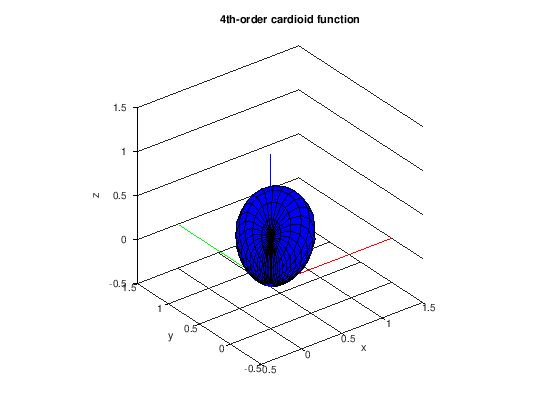

In [4]:
% plot function using the spherical plotting function
figure
plotSphFunctionGrid(Fdirs2grid(F,10,10,1), 10,10,'real',gca);
axis([-0.5 1.5 -0.5 1.5 -0.5 1.5]), view(3), title('4th-order cardioid function')

In [5]:
% construct different sampling grids for the SHT of order 4
regular_grid = grid2dirs(30,30);
Kreg = size(regular_grid,1); % regular grid with 62 points

[~, tdesign_grid] = getTdesign(2*Nord);
tdesign_grid = aziElev2aziIncl(tdesign_grid); % convert to azi-incl
Ktdesign = size(tdesign_grid,1); % t-design of 36 points

[~, fliege_grid, fliege_weights] = getFliegeNodes(Nord+1);
fliege_grid = aziElev2aziIncl(fliege_grid); % convert to azi-incl
Kfliege = size(fliege_grid,1); % fliege nodes 25 points

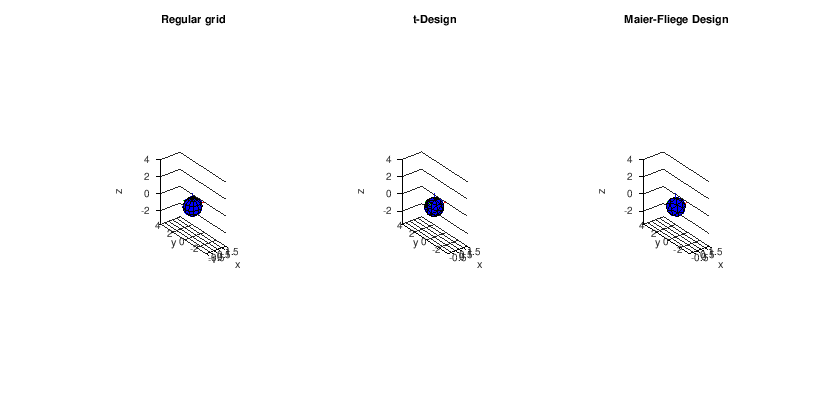

In [6]:
% plot the different grids using the spherical plot functions
figure
subplot(131); plotSphFunctionGrid(ones(length(0:30:180),length(0:30:360)), 30,30,'real', gca); view(3), title('Regular grid')
subplot(132); plotSphFunctionTriangle(ones(length(tdesign_grid),1), tdesign_grid, 'real', gca); view(3), title('t-Design')
subplot(133); plotSphFunctionTriangle(ones(length(fliege_grid),1), fliege_grid, 'real', gca); view(3), title('Maier-Fliege Design')
#h = gcf; h.Position(3) = 1.5*h.Position(3);
h = gcf;
pos = get(h, 'Position');
pos(3) .*= 1.5;
set(h, 'Position', pos)

In [7]:
% get integration weights for the (non-uniform) regular grid, based on
% areas of voronoi cells around the sampling points
regular_weights = getVoronoiWeights(aziElev2aziIncl(regular_grid));

In [8]:
% check conditioning of the transform for up to order 5 (one more order than 
% the sampling schemes are for)
cond_N_reg = checkCondNumberSHT(Nord+1, regular_grid, 'complex', []);
cond_N_reg_weighted = checkCondNumberSHT(Nord+1, regular_grid, 'complex', regular_weights);
cond_N_tdes = checkCondNumberSHT(Nord+1, tdesign_grid, 'complex', []);
cond_N_fliege = checkCondNumberSHT(Nord+1, fliege_grid, 'complex', []);
cond_N_fliege_weighted = checkCondNumberSHT(Nord+1, fliege_grid, 'complex', fliege_weights);

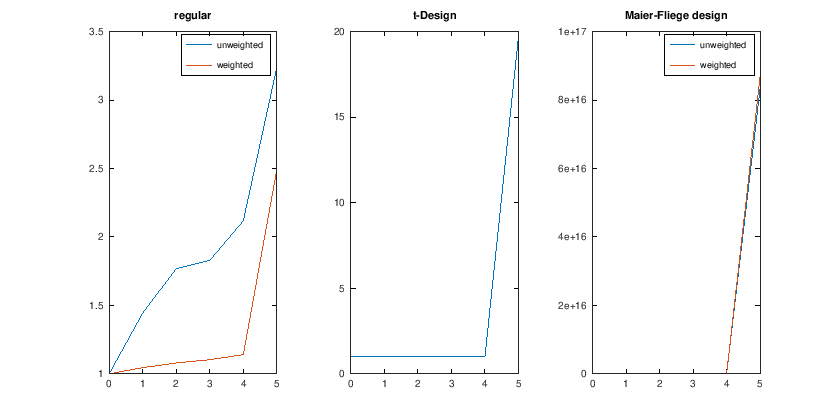

In [9]:
figure
subplot(131), plot(0:Nord+1, [cond_N_reg cond_N_reg_weighted]), title('regular'), legend('unweighted','weighted')
subplot(132), plot(0:Nord+1, cond_N_tdes), title('t-Design')
subplot(133), plot(0:Nord+1, [cond_N_fliege cond_N_fliege_weighted]), title('Maier-Fliege design'), legend('unweighted','weighted')
#h = gcf; h.Position(3) = 1.5*h.Position(3);
h = gcf;
pos = get(h, 'Position');
pos(3) .*= 1.5;
set(h, 'Position', pos)

## PERFORM SHT

Examples of performing SHT on data on a grid, using direct summation and
weighted least-squares.

In [10]:
% sample function on the respective grids
F_reg = fcardioid(regular_grid(:,1), regular_grid(:,2));
F_tdes = fcardioid(tdesign_grid(:,1), tdesign_grid(:,2));
F_fliege = fcardioid(fliege_grid(:,1), fliege_grid(:,2));

% perform SHT for the regular grid using weighted least-squares and complex SHs
Fnm_reg = leastSquaresSHT(Nord, F_reg, regular_grid, 'complex', regular_weights);
% perform SHT for the t-Design with direct non-weighted summation and complex SHs
Fnm_tdes = directSHT(Nord, F_tdes, tdesign_grid, 'complex', []);
% perform SHT for the Fliege nodes using weighted summation and complex SHs
Fnm_fliege = directSHT(Nord, F_fliege, fliege_grid, 'complex', fliege_weights);

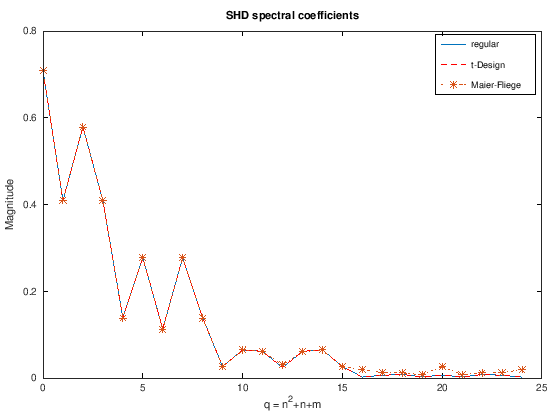

In [11]:
% plot coefficients
figure
plot(0:(Nord+1)^ 2-1, abs(Fnm_reg))
hold on, plot(0:(Nord+1)^ 2-1, abs(Fnm_tdes),'--r')
plot(0:(Nord+1)^ 2-1, abs(Fnm_fliege), '-.*')
legend('regular','t-Design','Maier-Fliege'), title('SHD spectral coefficients'), xlabel('q = n^2+n+m'), ylabel('Magnitude')

recreate the function at a dense grid from the SH coefficients (using
any of the above calculated coefficients) and plot reconstruction along
with error between reconstructed/interpolated function at the grid points
and the true values

In [12]:
Finterp = inverseSHT(Fnm_tdes, dirs, 'complex');
Ferror = abs(Finterp - F);

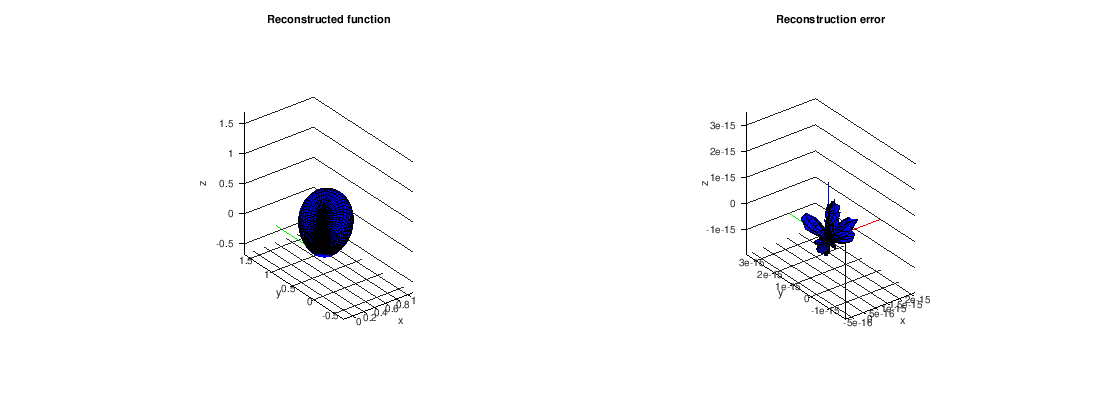

In [13]:
figure
subplot(121), plotSphFunctionCoeffs(Fnm_tdes, 'complex', 5, 5, 'real', gca); view(3), title('Reconstructed function')
subplot(122), plotSphFunctionGrid(Fdirs2grid(Ferror,10,10,1), 10,10,'real',gca); view(3), title('Reconstruction error')
#h = gcf; h.Position(3) = 2*h.Position(3);
h = gcf;
pos = get(h, 'Position');
pos(3) .*= 2.0;
set(h, 'Position', pos)

## INTEGRATION OF SPHERICAL FUNCTIONS

A test of the spectral theorem that states that the integral of the 
product of two functions is equal to the dot product of their 
respective spectral coefficients.

In [14]:
% Generate two random complex band-limited functions
Nf = 7;
Fnm = randn((Nf+1)^2,1) + 1i*randn((Nf+1)^2,1);
Ng = 5;
Gnm = randn((Ng+1)^2,1) + 1i*randn((Ng+1)^2,1);

% Generate a uniform grid for 12th-order integration
[~, tdesign_grid] = getTdesign(Nf+Ng);
Ktdes = size(tdesign_grid,1);

% Get the function values at the grid
Fgrid = inverseSHT(Fnm, aziElev2aziIncl(tdesign_grid), 'complex');
Ggrid = inverseSHT(Gnm, aziElev2aziIncl(tdesign_grid), 'complex');

% Integrate by direct summation
IntFG = (4*pi/Ktdes)*sum(Fgrid .* conj(Ggrid));

% Integrate directly using the SH coefficients
IntFG2 = Gnm(1:(min([Nf Ng])+1)^2)' * Fnm(1:(min([Nf Ng])+1)^2);

% Difference
disp(['Difference between integration in space and SH domain is ' num2str(IntFG - IntFG2)])

Difference between integration in space and SH domain is 1.0658e-14-8.4732e-13i


## ROTATION OF AN AXISYMMETRIC SPHERICAL FUNCTION ON THE SH DOMAIN

Rotation of general spherical functions directly by manipulation of their
SH coefficients is fairly complicated, apart from the case of an
axisymmetric function, which can be expressed as a weighted sum of
Legendre polynomials (or a weighted sum of spherical harmonics of degree
m=0). Such a function has N+1 non-zero SH coefficients. By rotating it to
some arbitrary direction, all the SH coefficients are populated.

In [15]:
% define a real axisymmetric random pattern directly in the spectral 
% domain (using only N+1 coefficients)
Nord = 6;
Fn = randn(Nord+1,1);

% target orientation to rotate the pattern
polar0 = pi/4;
azi0 = pi/4;
% fill the SH coefficients of the unrotated pattern with zeros for plotting
Fnm = rotateAxisCoeffs(Fn, 0,0, 'complex');
% SH coefficients of the rotated pattern
Fnm_rot = rotateAxisCoeffs(Fn, polar0, azi0, 'complex'); 

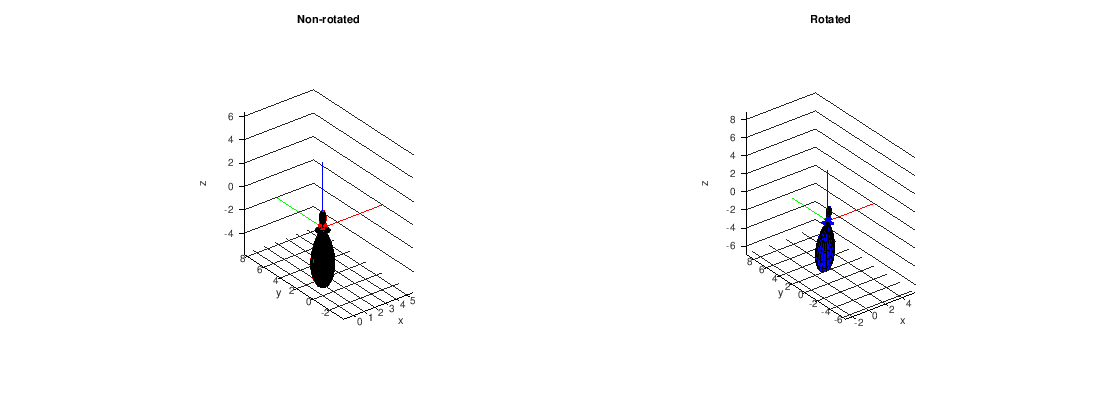

In [16]:
% plot the rotated and unrotated pattern
figure
subplot(121); plotSphFunctionCoeffs(Fnm, 'complex', 5,5, 'real', gca); view(3), title('Non-rotated')
subplot(122); plotSphFunctionCoeffs(Fnm_rot, 'complex', 5,5, 'real', gca); view(3), title('Rotated')
#h = gcf; h.Position(3) = 2*h.Position(3);
h = gcf;
pos = get(h, 'Position');
pos(3) .*= 2.0;
set(h, 'Position', pos)

## ROTATION OF A GENERAL SPHERICAL FUNCTION ON THE SH DOMAIN

General rotation of spherical function can be defined by a standard
rotation matrix acting on each point of the function in space. The same
effect can be achieved by expressing the rotation in the SH domain, in
which case the rotation matrix takes the form of a block diagonal matrix
with each block modifying the coefficients of each order separately. The
construction of these rotation matrices can be defined analytically in
terms of Wigner-D functions (for complex SHs), which however becomes too
slow to compute for high orders. Here a Wigner-D immplementation is included, 
(see WignerD() function) but a recursive method is prefered, which is much 
faster, implemented in getSHRotMtx(). This method is originally defined for 
real SHs, but it is trivial to get the rotation matrix for complex SHs
too, using the transformation matrices between the two bases included in
the library.

In [17]:
% resolution of the regular grid to plot the function
aziRes = 10;
polarRes = 10;

% desired orientation of the rotated function, in Euler Z-Y'-Z'' convention
alpha = pi/2;
beta = pi/2;
gamma = pi/4;

% define the rotation matrices succesively for plotting
R1 = euler2rotationMatrix(alpha, 0, 0, 'zyz');
R2 = euler2rotationMatrix(alpha, beta, 0, 'zyz');
R3 = euler2rotationMatrix(alpha, beta, gamma, 'zyz');

% generate random 3rd-order real function (directly in the SHD)
N = 3;
B_N = randn((N+1)^2,1);

% generate random 3rd-order complex function (directly in the SHD)
C_N = randn((N+1)^2,1) + 1i*randn((N+1)^2,1);

Rotate the function in the space domain directly, as reference for comparison

In [18]:
aziElev2aziIncl = @(dirs) [dirs(:,1) pi/2-dirs(:,2)]; % convert elevation to inclinations due to definition of spherical harmonics

% rotate the directions of the evaluation grid according to the euler
% angles
dirs = grid2dirs(aziRes, polarRes);
[U_dirs(:,1),U_dirs(:,2),U_dirs(:,3)] = sph2cart(dirs(:,1), pi/2-dirs(:,2), 1);
U_rot1 = U_dirs * R1.';
[dirs1(:,1),dirs1(:,2)] = cart2sph(U_rot1(:,1), U_rot1(:,2), U_rot1(:,3));
U_rot2 = U_dirs * R2.';
[dirs2(:,1),dirs2(:,2)] = cart2sph(U_rot2(:,1), U_rot2(:,2), U_rot2(:,3));
U_rot3 = U_dirs * R3.';
[dirs3(:,1),dirs3(:,2)] = cart2sph(U_rot3(:,1), U_rot3(:,2), U_rot3(:,3));
% compute the functions from their coefficients at the initial unrotated grid
B0 = inverseSHT(B_N, dirs, 'real');
C0 = inverseSHT(C_N, dirs, 'complex');

Obtain the rotation matrices in the spherical harmonic domain and apply
the three successive rotations for illustration

In [19]:
% rotation matrices using the recursive method for real SHs
R_rSH1 = getSHrotMtx(R1, N, 'real');
R_rSH2 = getSHrotMtx(R2, N, 'real');
R_rSH3 = getSHrotMtx(R3, N, 'real');

% rotated coefficients of real function
B_Nrot1 = R_rSH1*B_N;
B_Nrot2 = R_rSH2*B_N;
B_Nrot3 = R_rSH3*B_N;

% rotation matrices using the recursive method for complex SHs
D_cSH1 = getSHrotMtx(R1, N, 'complex');
D_cSH2 = getSHrotMtx(R2, N, 'complex');
D_cSH3 = getSHrotMtx(R3, N, 'complex');

% rotated coefficients of complex function
C_Nrot1 = D_cSH1*C_N;
C_Nrot2 = D_cSH2*C_N;
C_Nrot3 = D_cSH3*C_N;

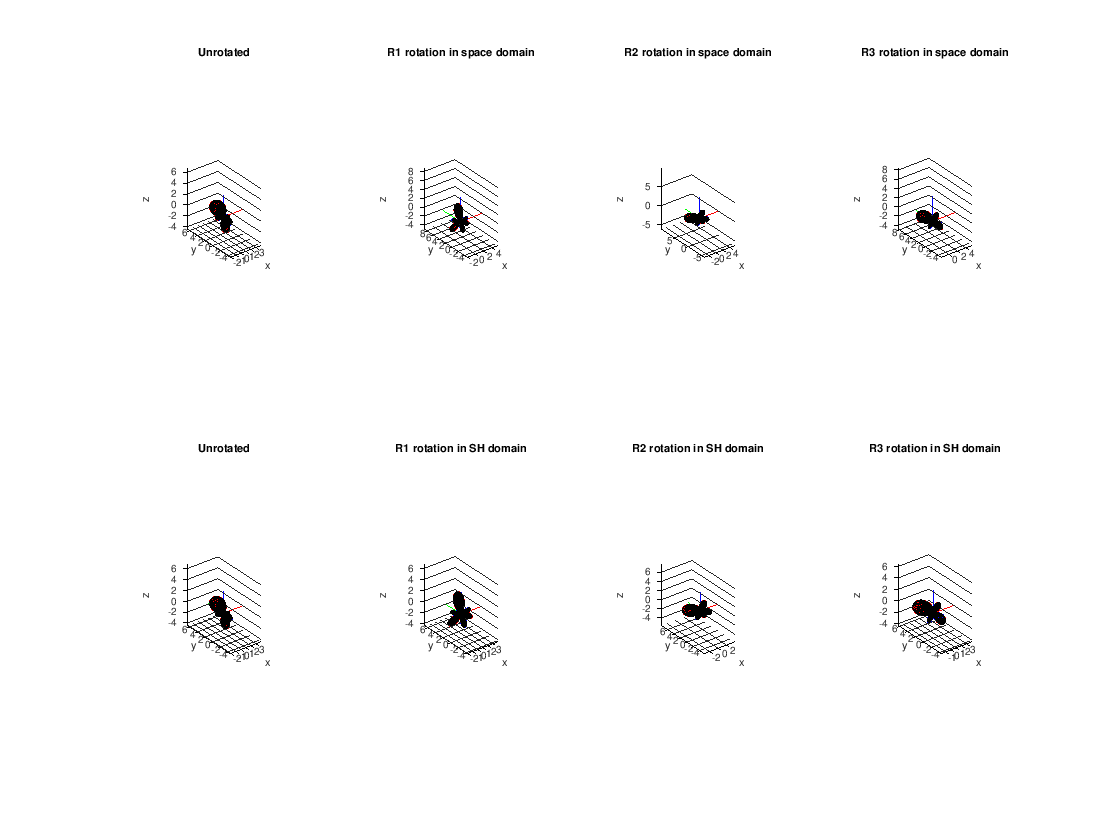

In [20]:
% plot the real function before and after rotation
figure;
subplot(241), plotSphFunctionCoeffs(B_N,'real',5,5,'real',gca); view(3), title('Unrotated')
subplot(242), plotSphFunctionTriangle(B0,aziElev2aziIncl(dirs1),'real',gca); view(3), title('R1 rotation in space domain')
subplot(243), plotSphFunctionTriangle(B0,aziElev2aziIncl(dirs2),'real',gca); view(3), title('R2 rotation in space domain')
subplot(244), plotSphFunctionTriangle(B0,aziElev2aziIncl(dirs3),'real',gca); view(3), title('R3 rotation in space domain')
subplot(245), plotSphFunctionCoeffs(B_N,'real',5,5,'real',gca); view(3), title('Unrotated')
subplot(246), plotSphFunctionCoeffs(R_rSH1*B_N ,'real',5,5,'real',gca); view(3), title('R1 rotation in SH domain')
subplot(247), plotSphFunctionCoeffs(R_rSH2*B_N,'real',5,5,'real',gca); view(3), title('R2 rotation in SH domain')
subplot(248), plotSphFunctionCoeffs(R_rSH3*B_N,'real',5,5,'real',gca); view(3), title('R3 rotation in SH domain')
#h = gcf; h.Position(3:4) = 2*h.Position(3:4);
h = gcf;
pos = get(h, 'Position');
pos(3:4) .*= 2.0;
set(h, 'Position', pos)

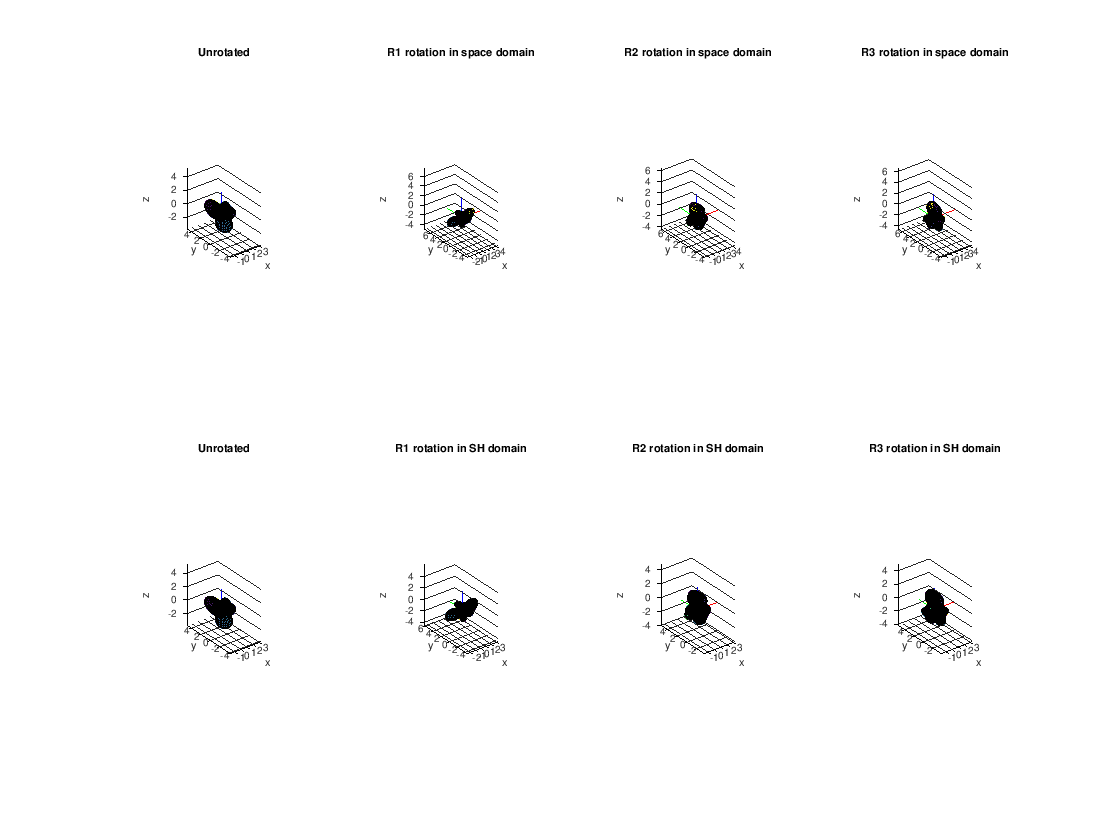

In [21]:
% plot the complex function before and after rotation
figure;
subplot(241), plotSphFunctionCoeffs(C_N,'complex',5,5,'complex',gca); view(3), title('Unrotated')
subplot(242), plotSphFunctionTriangle(C0,aziElev2aziIncl(dirs1),'complex',gca); view(3), title('R1 rotation in space domain')
subplot(243), plotSphFunctionTriangle(C0,aziElev2aziIncl(dirs2),'complex',gca); view(3), title('R2 rotation in space domain')
subplot(244), plotSphFunctionTriangle(C0,aziElev2aziIncl(dirs3),'complex',gca); view(3), title('R3 rotation in space domain')
subplot(245), plotSphFunctionCoeffs(C_N,'complex',5,5,'complex',gca); view(3), title('Unrotated')
subplot(246), plotSphFunctionCoeffs(D_cSH1*C_N,'complex',5,5,'complex',gca); view(3), title('R1 rotation in SH domain')
subplot(247), plotSphFunctionCoeffs(D_cSH2*C_N,'complex',5,5,'complex',gca); view(3), title('R2 rotation in SH domain')
subplot(248), plotSphFunctionCoeffs(D_cSH3*C_N,'complex',5,5,'complex',gca); view(3), title('R3 rotation in SH domain')
#h = gcf; h.Position(3:4) = 2*h.Position(3:4);
h = gcf;
pos = get(h, 'Position');
pos(3:4) .*= 2.0;
set(h, 'Position', pos)

An example of constructing the rotation matrices using the Wigner-D
matrices

In [22]:
% rotate complex coefficients directly through Wigner-D matrices, for
% comparison with the recursive method
W_cSH3 = zeros((N+1)^2);
% zeroth order
W_cSH3(1) = 1;

band_idx = 1;
for l = 1:N  
    [~,~,W_cSH3(band_idx+(1:2*l+1), band_idx+(1:2*l+1))] = wignerD(l, alpha, beta, gamma);    
    band_idx = band_idx + 2*l+1;
end

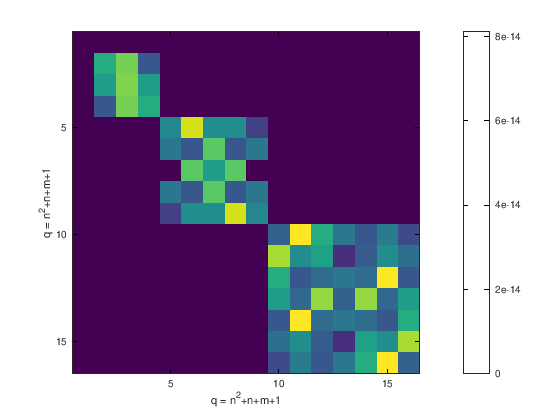

In [23]:
% plot difference between rotation matrix by recursive method and direct
% computation by Wigner-D
diff_mtx = abs(D_cSH3 - W_cSH3);
figure
imagesc(diff_mtx), colorbar, xlabel('q = n^2+n+m+1'), ylabel('q = n^2+n+m+1')

## CONVOLUTION OF ONE FUNCTION WITH AN AXISYMMETRIC KERNEL

This script shows the result of the convolution of a spherical 
function x of order N=8 by a spherical filter h of lower order N=4. 
The original, filter and output functions are plotted. It's evident
that the result is of the lower order of the filter, which act as a
lowpass and eliminates the higher harmonics.

In [24]:
% generate a random complex 6th-order function
Nx = 6;
Xnm = randn((Nx+1)^2,1) + 1i*randn((Nx+1)^2,1);
% generate a random real 4th-order kernel
Nh = 4;
Hn = randn((Nh+1),1);
% fill the SH coefficients of the unrotated pattern with zeros for plotting
Hnm = rotateAxisCoeffs(Hn, 0,0, 'complex');

% perform convolution
Ynm = sphConvolution(Xnm, Hn);

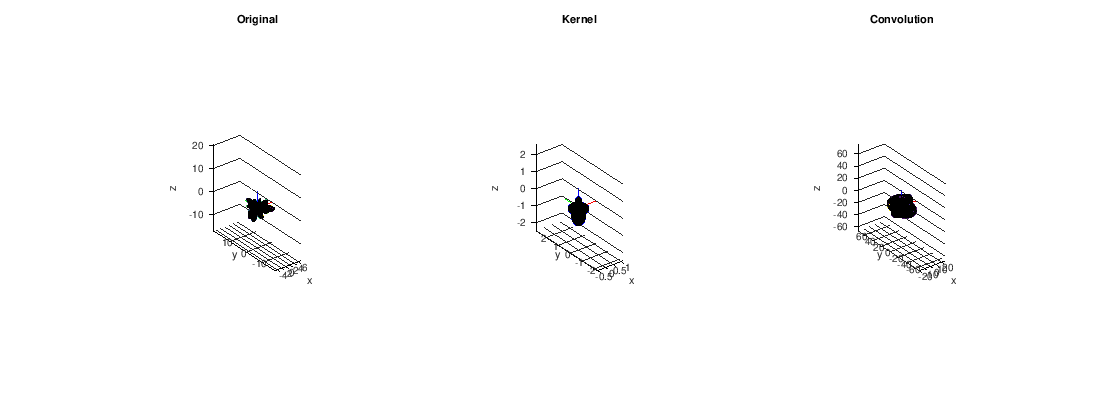

In [25]:
% plot original function, kernel and output function
figure
subplot(131); plotSphFunctionCoeffs(Xnm, 'complex', 5,5, 'complex', gca); view(3), title('Original')
subplot(132); plotSphFunctionCoeffs(Hnm, 'complex', 5,5, 'real', gca); view(3), title('Kernel')
subplot(133); plotSphFunctionCoeffs(Ynm, 'complex', 5,5, 'complex', gca); view(3), title('Convolution')
#h = gcf; h.Position(3) = 2*h.Position(3);
h = gcf;
pos = get(h, 'Position');
pos(3) .*= 2.0;
set(h, 'Position', pos)

## SOME MORE MANIPULATIONS OF SH COEFFICIENTS

### SH COEFFICIENTS OF CONJUGATE FUNCTION

The coefficients of a conjugate function can be obtained directly by the 
coefficients of the original function. These are returned by the
conjCoeffs() function.

In [26]:
% generate a 4th-order complex function and get its values on a uniform
% grid
Nf = 6;
Fnm = randn((Nf+1)^2,1) + 1i*randn((Nf+1)^2,1);
[~, tdesign_grid] = getTdesign(2*Nf);
F_fliege = inverseSHT(Fnm, aziElev2aziIncl(tdesign_grid), 'complex');

% compute the SH coefficients of its conjugate function
G_fliege = conj(F_fliege);
Gnm = directSHT(Nf, G_fliege, aziElev2aziIncl(tdesign_grid), 'complex', []);

% compute coefficients of the conjugate function directly in the SH domain
Gnm_direct = conjCoeffs(Fnm);

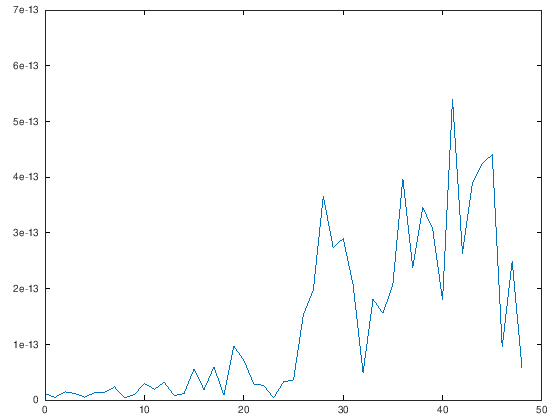

In [27]:
% plot difference of the two
figure
plot(0:(Nf+1)^ 2-1, abs(Gnm - Gnm_direct))

### CONVERSION BETWEEN REAL AND COMPLEX SH COEFFICIENTS

Conversion between real and complex SHs can be done by specific unitary
transformation matrices, returned by the functions complex2realSHMtx()
and real2complexSHMtx(). To obtain directly the coefficients from one
base to the other, use complex2realCoeffs() and real2complexCoeffs()
instead.

In [28]:
% generate a random axisymmetric 4th-order function and rotate to some
% angle (polar0, azi0)
Nc = 4;
c_n = randn(Nc+1,1);
polar0 = pi/4;
azi0 = pi/4;

% get the SH coefficients of the rotated pattern into the two different
% bases
c_nm = rotateAxisCoeffs(c_n, polar0, azi0, 'complex');
r_nm = rotateAxisCoeffs(c_n, polar0, azi0, 'real');

% convert from one base to the other by conversion matrix
r_nm2 = complex2realCoeffs(c_nm);
c_nm2 = real2complexCoeffs(r_nm);

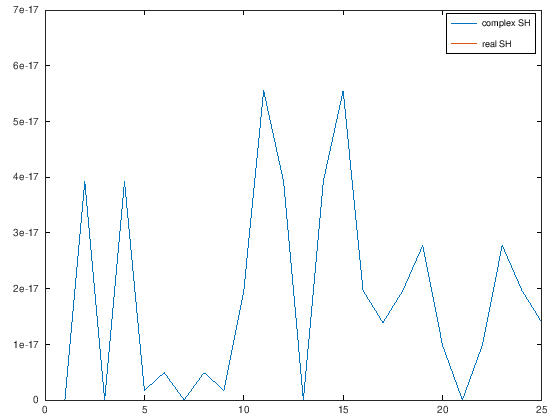

In [29]:
% plot difference
figure
plot(abs([(c_nm - c_nm2) (r_nm - r_nm2)])), legend('complex SH','real SH')

## GAUNT COEFFICIENTS AND SPHERICAL MULTIPLICATION

The Gaunt coefficient gives the integral of the product of three
spherical harmonics and can be used in obtaining the coefficients of the
product of two spherical functions directly from their respective
coefficients. The example below tests that the coefficients of a product 
function of two spherical functions are equal to the ones derived directly 
by employing Gaunt coefficients (slow for high orders)

#### (Octave) Installation of symbolic package

In [30]:
pkg install -forge symbolic

For information about changes from previous versions of the symbolic package, run 'news symbolic'.


In [31]:
pkg load symbolic

In [32]:
# because of https://github.com/sympy/sympy/pull/18245, we have to use sympy 1.5 currently(2020/12/13).
!pip install -U sympy==1.5

parse error:

  syntax error

>>> !pip install -U sympy==1.5
               ^



In [33]:
syms x

Symbolic pkg v2.9.0: Python communication link active, SymPy v1.5.


In [36]:
help sym

'sym' is a function from the file /home/jovyan/octave/symbolic-2.9.0/@sym/sym.m

 -- Constructor on @sym: X = sym (Y)
 -- Constructor on @sym: X = sym (Y, ASSUMESTR)
 -- Constructor on @sym: X = sym (Y, ASSUMESTR1, ASSUMESTR2, ...)
 -- Constructor on @sym: X = sym (A, [N, M])
 -- Constructor on @sym: X = sym (Y, RATFLAG)
 -- Constructor on @sym: X = sym (HANDLE)
     Define symbols and numbers as symbolic expressions.

     Y can be an integer, a string or one of several special double
     values.  It can also be a double matrix or a cell array.

     Examples:
          x = sym ('x')
            ⇒ x = (sym) x
          y = sym ('2')
            ⇒ y = (sym) 2
          y = sym (3)
            ⇒ y = (sym) 3
          y = sym (inf)
            ⇒ y = (sym) ∞
          y = sym (pi)
            ⇒ y = (sym) π
          y = sym (1i)
            ⇒ y = (sym) ⅈ

     A sym of a sym is a sym (idempotence):
          sym (sym (pi))
            ⇒ (sym) π

     A matrix of integers can be input:
  

#### GAUNT COEFFICIENTS AND SPHERICAL MULTIPLICATION (continue)

In [34]:
% Generate two random complex band-limited functions
Nf = 4;
Fnm = randn((Nf+1)^2,1) + 1i*randn((Nf+1)^2,1);
Ng = 2;
Gnm = randn((Ng+1)^2,1) + 1i*randn((Ng+1)^2,1);

% Generate a uniform grid for 12th-order integration
[~, tdesign_grid] = getTdesign(2*(Nf+Ng));

% Get the function values at the grid and that of the product function
Fgrid = inverseSHT(Fnm, aziElev2aziIncl(tdesign_grid), 'complex');
Ggrid = inverseSHT(Gnm, aziElev2aziIncl(tdesign_grid), 'complex');
Cgrid = Fgrid.*Ggrid;

In [35]:
% Get the SH coefficents of the product function by SHT
Cnm = directSHT(Nf+Ng, Cgrid, aziElev2aziIncl(tdesign_grid), 'complex', []);

In [55]:
% Get the coefficients of the product in the SH domain through Gaunt
% coefficients
Cnm_gaunt = sphMultiplication(Fnm, Gnm);

0
 1
 2
 3
 4
 5
 6


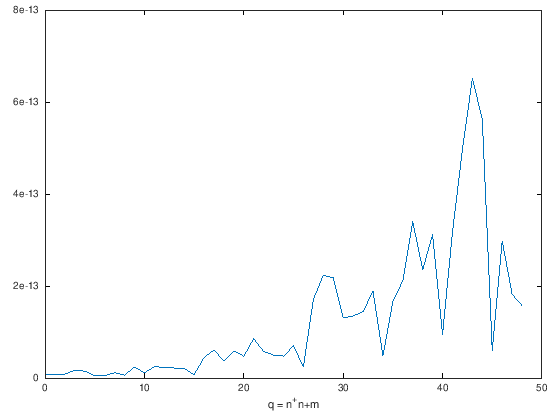

In [56]:
% Plot difference
figure
plot(0:(Nf+Ng+1)^2-1, abs(Cnm - Cnm_gaunt)), xlabel('q = n^+n+m')

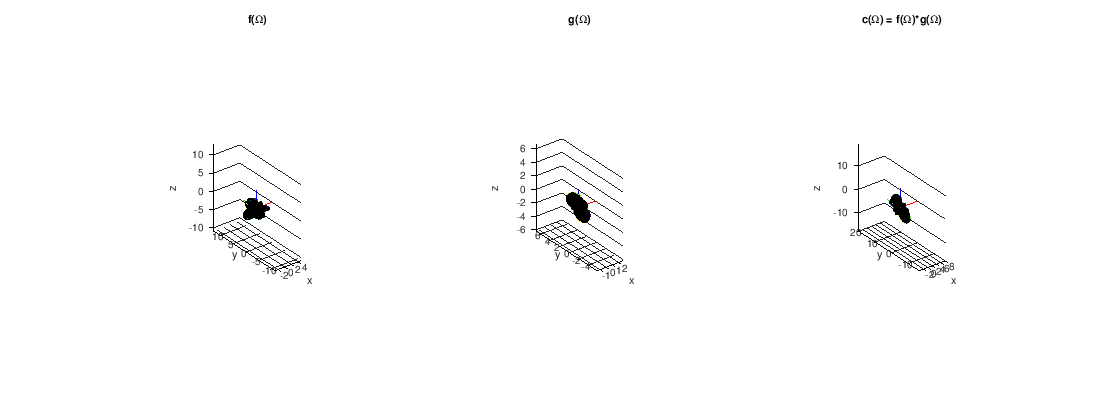

In [58]:
% plot member functions and product function
figure
subplot(131); plotSphFunctionCoeffs(Fnm, 'complex', 5,5, 'complex', gca); view(3), title('f(\Omega)')
subplot(132); plotSphFunctionCoeffs(Gnm, 'complex', 5,5, 'complex', gca); view(3), title('g(\Omega)')
subplot(133); plotSphFunctionCoeffs(Cnm_gaunt, 'complex', 5,5, 'complex', gca); view(3), title('c(\Omega) = f(\Omega)*g(\Omega)')
#h = gcf; h.Position(3) = 2*h.Position(3);
h = gcf;
pos = get(h, 'Position');
pos(3) .*= 2.0;
set(h, 'Position', pos)

## PLOTTING

Test the three different functions for plotting 3-dimensional plots

### CASE 1: Plot function from its coefficients. 

Real functions can be plotted with the argument 'real', where blue-red 
shows positive/negative values respectively. For complex functions, use 
the argument 'complex', the full colormap shows the complex phase.
Additionally, another 'real' or 'complex argument should be passed
depending if the spectral coefficients have been computed for real or
complex SHs. This is independent of the funcion being real or complex.

In [63]:
% plotting grid resolution
aziRes = 5;
polarRes = 5;

% get the coefficients of a 4th-order band-limited Dirac function at (45,45) degrees
% on the real SH basis
rSHbasisType = 'real';
R_N = getSH(4, [pi/4 pi/4], rSHbasisType)';

% get the coefficients of a 4th-order band-limited Dirac function at (45,45) degrees
% on the complex SH basis (should look the same as the real case)
cSHbasisType = 'complex';
C_N = getSH(4, [pi/4 pi/4], cSHbasisType)';

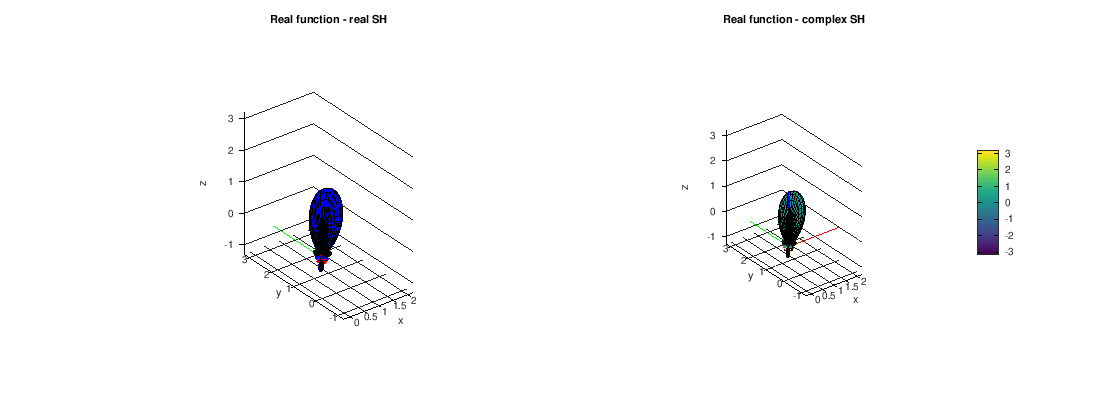

In [64]:
figure
subplot(121), plotSphFunctionCoeffs(R_N, rSHbasisType, aziRes, polarRes, 'real', gca); view(3), title('Real function - real SH')
subplot(122), plotSphFunctionCoeffs(C_N, cSHbasisType, aziRes, polarRes, 'complex', gca); view(3), colorbar, title('Real function - complex SH')
#h = gcf; h.Position(3) = 2*h.Position(3);
h = gcf;
pos = get(h, 'Position');
pos(3) .*= 2.0;
set(h, 'Position', pos)

### CASE 2: Plot function defined on a regular grid. 

Here the two helper functions grid2dirs() and Fdirs2grid() are useful. The 
first takes a polar and azimuthal resolution and return the vector of directions,
omitting duplicates at the poles. After the function has been evaluated
at these grid directions, it can be reshaped back to a 2D array ready for
plotting, using Fdirs2grid().

In [65]:
% analytical expression for a real directional function 
% (3rd-order dipole)
fcosAlpha = @(azi, polar, azi0, polar0) cos(polar)*cos(polar0) + ...
    sin(polar)*sin(polar0).*cos(azi-azi0);  % function for dipole oriented at azi0, polar0
Nord = 3;
polar0 = pi/4;
azi0 = pi/4;
fdipole = @(azi, polar) (fcosAlpha(azi, polar, azi0, polar0)).^Nord;

% sample function at grid directions
aziRes = 5;
polarRes = 2;
grid_dirs = grid2dirs(aziRes, polarRes);
R = fdipole(grid_dirs(:,1), grid_dirs(:,2));
% reshape back to 2D array
Rgrid = Fdirs2grid(R,aziRes,polarRes,1);

% plot a complex 4-th order function defined on a grid 
% (just a single complex spherical harmonic)
C = getSH(4, grid_dirs, 'complex');
C = C(:,20);
% reshape back to 2D array
Cgrid = Fdirs2grid(C,aziRes,polarRes,1);

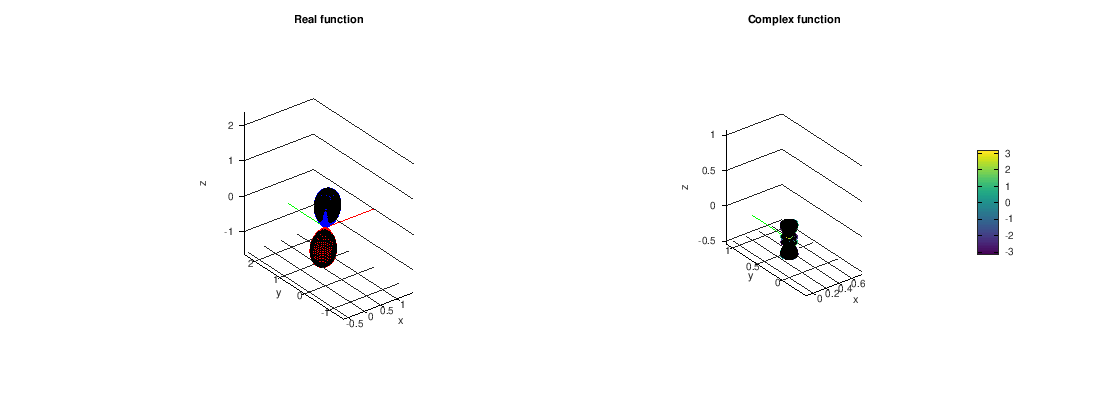

In [66]:
figure
subplot(121), plotSphFunctionGrid(Rgrid, aziRes, polarRes, 'real', gca); view(3), title('Real function')
subplot(122), plotSphFunctionGrid(Cgrid, aziRes, polarRes, 'complex', gca); view(3), colorbar, title('Complex function')
#h = gcf; h.Position(3) = 2*h.Position(3);
h = gcf;
pos = get(h, 'Position');
pos(3) .*= 2.0;
set(h, 'Position', pos)

### CASE 3: Plot function defined on arbitrary points. 

Data sampled on non-regular grids can be plotted using the
plotSphFunctionTriangle() function. It first triangulates the set of
points passed to the functon and then plots the result, with real/complex
arguments similar to the previous two functions.

In [67]:
% get a unifrom arrangement of sampling points such as a tDesign
[~, tdesign_dirs] = getTdesign(21);
% convert from azi-elev to azi-inclination
tdesign_dirs = [tdesign_dirs(:,1) pi/2-tdesign_dirs(:,2)];

% analytical expression for a real directional function 
% (3rd-order dipole)
fcosAlpha = @(azi, polar, azi0, polar0) cos(polar)*cos(polar0) + ...
    sin(polar)*sin(polar0).*cos(azi-azi0);  % function for dipole oriented at azi0, polar0
Nord = 3;
polar0 = pi/4;
azi0 = pi/4;
fdipole = @(azi, polar) (fcosAlpha(azi, polar, azi0, polar0)).^Nord;

R = fdipole(tdesign_dirs(:,1), tdesign_dirs(:,2));

% plot a complex 4-th order function defined on a grid 
% (just a single complex spherical harmonic)
C = getSH(4, tdesign_dirs, 'complex');
C = C(:,20);

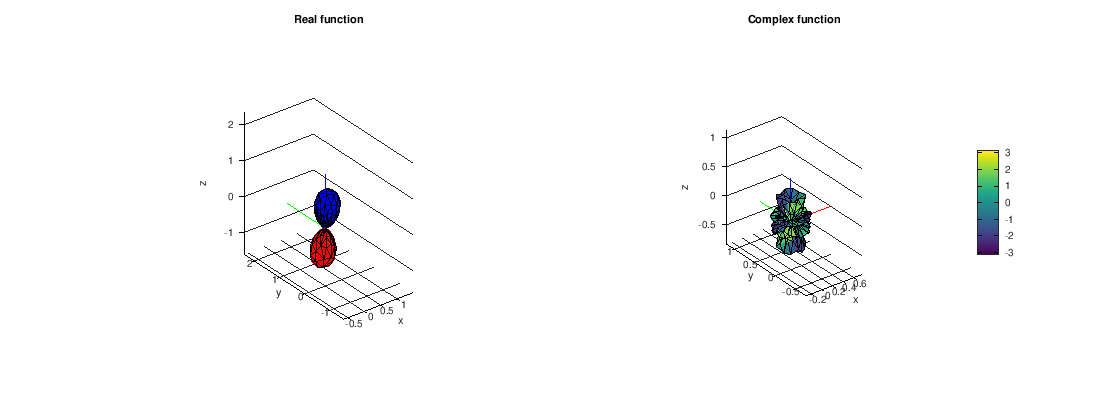

In [68]:
figure
subplot(121), plotSphFunctionTriangle(R, tdesign_dirs, 'real', gca); view(3), title('Real function')
subplot(122), plotSphFunctionTriangle(C, tdesign_dirs, 'complex', gca); view(3), colorbar, title('Complex function')
#h = gcf; h.Position(3) = 2*h.Position(3);
h = gcf;
pos = get(h, 'Position');
pos(3) .*= 2.0;
set(h, 'Position', pos)

## REFERENCES

[1] McLaren's Improved Snub Cube and Other New Spherical Designs in Three Dimensions, 
    R. H. Hardin and N. J. A. Sloane, 
    Discrete and Computational Geometry, 15 (1996), pp. 429-441.

[2] The distribution of points on the sphere and corresponding cubature formulae, 
    J. Fliege and U. Maier, 
    IMA Journal of Numerical Analysis (1999), 19 (2): 317-334

[3] Translational addition theorems for spherical vector wave functions, 
    O. R. Cruzan, Quart. Appl. Math. 20, 33:40 (1962)

[4] Rotation Matrices for Real Spherical Harmonics. Direct Determination by Recursion. 
    Ivanic, J., Ruedenberg, K. (1996).  
    The Journal of Physical Chemistry, 100(15), 6342:6347.

[5] Rotation Matrices for Real Spherical Harmonics. Direct Determination by Recursion Page: Additions and Corrections. 
    Ivanic, J., Ruedenberg, K. (1998).  
    Journal of Physical Chemistry A, 102(45), 9099:9100.
